In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm
from smt.kernels import Constant
from smt.kernels import PowExp
from smt.surrogate_models import KRG

In [18]:
# Quantile functions
def quantile_cp(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.ceil((1 - alpha) * (n + 1)) - 1)]
    return q


def quantile_cp_minus(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.floor(alpha * (n + 1)) - 1)]
    return q

## Activity 1: Towards local adaptivity

### Data generation

In [19]:
# Function to generate random heteroskedastic data
def make_random_data(n, std_dev):
    x = np.random.uniform(-1, 1, n)
    y = x**3 + 2 * np.exp(-6 * (x - 0.3) ** 2)
    y = y + np.random.normal(0, std_dev * np.abs(x), n)
    return pd.DataFrame({"x": x, "y": y})


# Generate train and test data
np.random.seed(12345)
ntrain = 1000
ntest = 1000
nvisu = 1000
std_dev = 1 / 5
train_data = make_random_data(ntrain, std_dev)
test_data = make_random_data(ntest, std_dev)
visu_data = pd.DataFrame({"x": np.linspace(-1, 1, nvisu)})

In [20]:
# Sample split
ncal = 100
npretrain = ntrain - ncal
train_data = train_data.sample(frac=1).reset_index(drop=True)
pretrain_data = train_data.iloc[:npretrain]
cal_data = train_data.iloc[npretrain:]

alpha = 0.1

### Rescaled scores with GP

In [24]:
k = PowExp([0.01]) * Constant([0.01])


gp = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)

# Pretraining Gaussian Process
X_pretrain = pretrain_data["x"].values.reshape(-1, 1)
y_pretrain = pretrain_data["y"].values
gp.set_training_values(X_pretrain, y_pretrain)
gp.train()
gp_pred_pretrain = gp.predict_values(X_pretrain)[:, 0]
gp_std_pretrain = np.sqrt(gp.predict_variances(X_pretrain))[:, 0]

# Compute residuals and fit another GP on residuals
res_gp_pred_pretrain = np.abs(y_pretrain - gp_pred_pretrain)
gp_res = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)
gp_res.set_training_values(X_pretrain, res_gp_pred_pretrain)
gp_res.train()

# Predictions on calibration data
X_cal = cal_data["x"].values.reshape(-1, 1)
y_cal = cal_data["y"].values
gp_pred_cal = gp.predict_values(X_cal)[:, 0]
gp_std_cal = np.sqrt(gp.predict_variances(X_cal))[:, 0]
gp_res_pred_cal = gp_res.predict_values(X_cal)[:, 0]

res_gp_pred_cal = np.abs(y_cal - gp_pred_cal) / gp_res_pred_cal
gp_q_cal = quantile_cp(res_gp_pred_cal, alpha)

# Predictions for visualization data
X_visu = visu_data["x"].values.reshape(-1, 1)
gp_pred_visu = gp.predict_values(X_visu)[:, 0]
gp_std_visu = np.sqrt(gp.predict_variances(X_visu))[:, 0]
gp_res_pred_visu = gp_res.predict_values(X_visu)[:, 0]

# Compute lower and upper bounds for the GP with rescaling based on residuals
gp_pred = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu,
        ".pred_lower": gp_pred_visu - gp_res_pred_visu * gp_q_cal,
        ".pred_upper": gp_pred_visu + gp_res_pred_visu * gp_q_cal,
    }
)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 900
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 16.4207468
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 900
   
   Predicting ...
   Predicting - done. Time (sec):  0.0248420
   
   Prediction time/pt. (sec) :  0.0000276
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 900
   
___________________________________________________________________________
   
 Tr

In [25]:
# GP with rescaling from posterior standard deviation
gp_pred_cal2 = gp.predict_values(X_cal)[:, 0]
gp_std_cal2 = np.sqrt(gp.predict_variances(X_cal))[:, 0]
res_gp_pred_cal2 = np.abs(y_cal - gp_pred_cal2) / gp_std_cal2
gp_q_cal2 = quantile_cp(res_gp_pred_cal2, alpha)

gp_pred_visu2 = gp.predict_values(X_visu)[:, 0]
gp_std_visu2 = np.sqrt(gp.predict_variances(X_visu))[:, 0]

gp_pred2 = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu2,
        ".pred_lower": gp_pred_visu2 - gp_std_visu2 * gp_q_cal2,
        ".pred_upper": gp_pred_visu2 + gp_std_visu2 * gp_q_cal2,
    }
)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0036786
   
   Prediction time/pt. (sec) :  0.0000368
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0227671
   
   Prediction time/pt. (sec) :  0.0000228
   


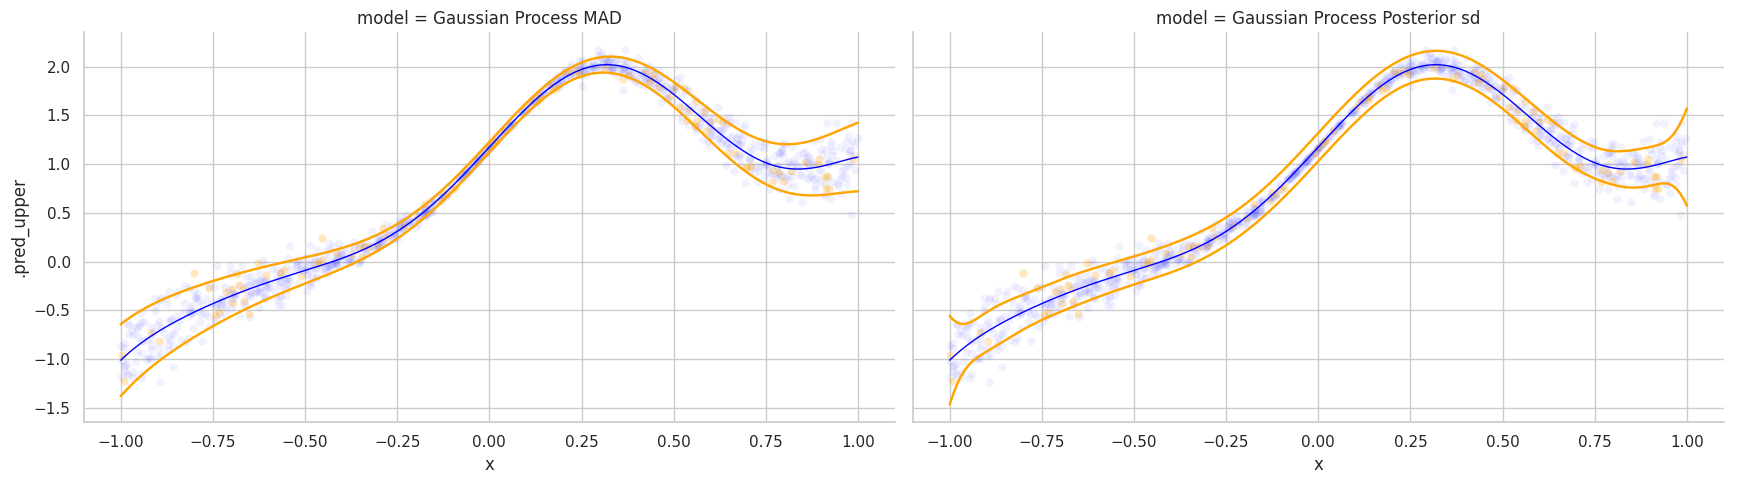

In [32]:
# Combine and visualize
model_list = {
    "Gaussian Process MAD": gp_pred,
    "Gaussian Process Posterior sd": gp_pred2,
}
all_pred = (
    pd.concat(model_list, names=["id"])
    .reset_index(level=0)
    .rename(columns={"id": "model"})
)

sns.set(style="whitegrid")
g = sns.FacetGrid(all_pred, col="model", height=5, aspect=1.75)
g.map(plt.plot, "x", ".pred", color="blue", lw=1)
g.map(plt.plot, "x", ".pred_lower", color="orange", lw=1.75)
g.map(plt.plot, "x", ".pred_upper", color="orange", lw=1.75)
for ax in g.axes.flat:
    sns.scatterplot(
        x=pretrain_data["x"], y=pretrain_data["y"], color="blue", alpha=0.05, ax=ax
    )
    sns.scatterplot(x=cal_data["x"], y=cal_data["y"], color="orange", alpha=0.25, ax=ax)

g.add_legend()

plt.show()